## Style Transfer

Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter) and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.
This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

Ex: 

<img src='https://149695847.v2.pressablecdn.com/wp-content/uploads/2020/06/1_kOQOZxBDNw4lI757soTEyQ.png' width=800/>

## Importing Necessary Libraries

In [1]:
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import tensorflow as tf

## Loading Content and Style images

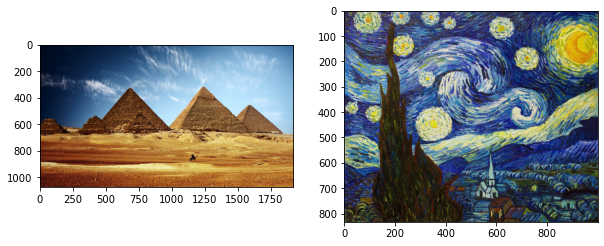

In [4]:
img_nrows, img_ncols = 640, 320

content = plt.imread('imgs/content.jpg')
style = plt.imread('imgs/style.jpg')

figure, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(content)
axs[1].imshow(style)
plt.show()

## Understanding how a Neural Style Transfer works

If we want to code a Neural Style Transfer, the first thing we must do is to perfectly understand how convolutional neural networks work. In my case, I already talked about them in this post, although today it will be more specific.

In order for a Neural Style Transfer network to work, we must achieve at least two things:

* Convey the style as much as possible.
* Assure that the resulting image look as close to the original image as possible.

We could consider a third objective: making the resulting image as internally coherent as possible. This is something that Keras’s implementation includes but that, in my case, I am not going to dive into.

To do this, a neural style transfer network has the following:

* A convolutional neural network already trained (such as VGG19 or VGG16). Three images will be passed to this network: the base image, the style image, and the combination image. The latter could be both a noise image and the base image, although generally the base image is passed in order to make the resulting image look similar and to speed up the process.
* The combined image is optimized and steadily changes in such a way that it takes the styles of the style image while maintaining the content of the base image. To do this, we will optimize the image using two different losses (style and content).

<img src='https://miro.medium.com/max/1924/0*F4F_8DzBkBFh3XWi' width=800/>


## How to transfer the style of an image

In convolutional neural networks, the deeper we go into the network, the more complex shapes the network distinguishes. This is something that can be clearly seen in the ConvNet Playground application, which allows you to see the layer channels at different “depths” of the network.

Therefore, if we want to transfer the style of an image, we will have to make the values of the features of the deep layers of our network look like those of the network of the style image.

But how can we calculate the loss function of this process in order to adjust it? For this, we use the so-called Gram Matrix.

## The Gram Matrix

Suppose we want to calculate the style loss on a layer. To do this, the first thing we must do is flatten our layer. This is a good thing, as the Gram Matrix calculation will not change based on the size of the layer.

<img src='https://sp-ao.shortpixel.ai/client/to_webp,q_glossy,ret_img,w_468/https://anderfernandez.com/wp-content/uploads/2020/10/Gram-Matrix.png' >

So, suppose we do a flatten on a layer of 3 filters. Well, the Gram Matrix shows the similarity between the filters and is obtained by calculating the dot product between the vectors:
When we are calculating dot products, we are taking the distance into account: the smaller the dot product, the closer the two vectors are and vice versa.

In [5]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

## Define Style and Content costs

In [6]:
def style_cost(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [7]:
def content_cost(content, combination):
    return tf.reduce_sum(tf.square(combination - content))

## Loading the VGG19 Model

In [11]:
model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)
print(model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Calculation of loss functions

Now that we have the model, we must create a function that extracts the values of that model for some given layers (in this way we can use it for both the content error and the style error).

To calculate the loss we will follow the following steps:

* Combine all the images in the same tensor.
* Get the values in all the layers for the three images. Yes, it is true that we will not need all the values of all the images, but this will be easier since we will already have everything extracted. In fact, if we wanted to change the extraction of styles, it would also be very simple.
* Initialize the loss vector where we will add the results.
* Extract the content layers for the base image and merge and calculate the content loss function.
* Extract the style layers for the style image and the combination image and calculate the style loss function.

In [12]:
outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [13]:
cap_style = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

cap_content = "block5_conv2"

content_weight = 2.5e-8
style_weight = 1e-6

def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combine all the images in the same tensioner.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Get the values in all the layers for the three images.
    features = feature_extractor(input_tensor)

    #3. Inicializar the loss

    loss = tf.zeros(shape=())

    # 4. Extract the content layers + content loss
    layer_features = features[cap_content]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * content_cost(
        base_image_features, combination_features
    )
    # 5. Extraer the style layers + style loss
    for layer_name in cap_style:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_cost(style_reference_features, combination_features)
        loss += (style_weight / len(cap_style)) * sl

    return loss

In [14]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## Preprocess and deprocess images

The preprocessing of the images consists of giving the images the format that our network requires. In the case of Keras, as it is the VGG19 model, the model itself has an image preprocessing function: preprocess_input.

Keep in mind that Keras works with image batches. Therefore, the information we pass on must be in this format. To do this, carry out the following processes:

* load_image: we upload an image and give it a specific shape.
* img_to_array: we convert the loaded image into an array that considers the number of channels. In our case, being color images, we will have three channels, while a black and white image would have only one channel.
* expand_dims: we group all the images in a single array, since, as we have said, Keras works with batches of images. Thus, the result of this step will be an array with shape (3, width, height, 3).
* preprocess_input: subtract the mean of the RGB values from the Imagenet dataset (with which VGG19 is trained), in such a way that we get the images to have zero average. This is a typical preprocessing in images, as this prevents gradients from being too “extreme”, thus achieving better model results (link).
* convert_to_tensor: finally, we are going to convert our already centered array into a data type that Tensorflow understands. For that, we will simply convert it to a tensor with this function.

In [15]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

## Deprocess the image

In [16]:
def deprocess_image(x):

    x = x.reshape((img_nrows, img_ncols, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype("uint8")

    return x

## Saving the generated image

In [17]:
def result_saver(iteration):
    now = datetime.now()
    now = now.strftime("%Y%m%d_%H%M%S")
    image_name = str(i) + '_' + str(now)+"_image" + '.png'

    # Save image
    img = deprocess_image(combination_image.numpy())
    tf.keras.preprocessing.image.save_img(image_name, img)

In [19]:
width, height = tf.keras.preprocessing.image.load_img('imgs/content.jpg').size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image('imgs/content.jpg')
style_reference_image = preprocess_image('imgs/style.jpg')
combination_image = tf.Variable(preprocess_image('imgs/content.jpg'))

iterations = 200

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Iteration 10: loss=14360.29
Iteration 20: loss=7852.43
Iteration 30: loss=5513.53
Iteration 40: loss=4351.25
Iteration 50: loss=3655.73
Iteration 60: loss=3190.84
Iteration 70: loss=2856.34
Iteration 80: loss=2602.90
Iteration 90: loss=2402.31
Iteration 100: loss=2238.23
Iteration 110: loss=2101.23
Iteration 120: loss=1984.28
Iteration 130: loss=1882.67
Iteration 140: loss=1793.39
Iteration 150: loss=1714.06
Iteration 160: loss=1642.90
Iteration 170: loss=1578.78
Iteration 180: loss=1520.56
Iteration 190: loss=1467.42
Iteration 200: loss=1418.68


## Displaying the output of 200 Iterations

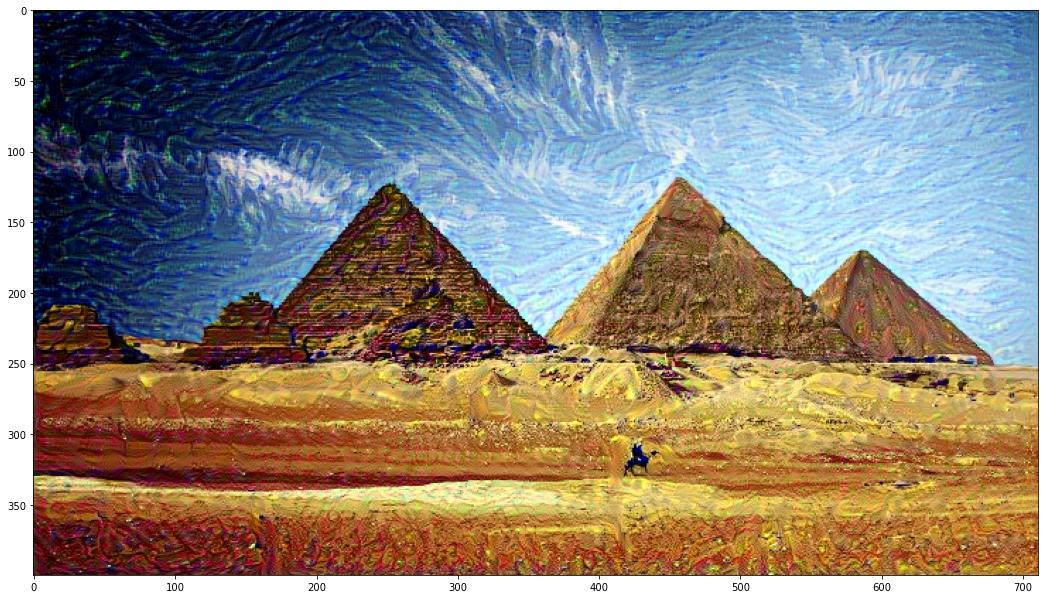

In [24]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(plt.imread('imgs/200.png'))